In [1]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split

from datetime import datetime
import sys
sys.path.insert(1, '/afs/desy.de/user/a/axelheim/private/MC_studies/Dstlnu_Bt_generic/util_funcs/')
from pandas_colFuncs import isBtoDstlnu, whichBisSig, customMCmatching, B_ID, whichBisSig_NAHS

In [2]:
root_path = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/SHR_Hc_correctReco_BsX/SHR_CMvars_run1/"

## load root files

In [3]:
merged="merged_"

In [4]:
fileY4S = uproot.open(root_path + merged + "DXtagDstl.root:variables")
df_Y4S = fileY4S.arrays(library="pd")

In [5]:
names = ["gammas","electrons","pions","kaons","muons"]
dfs = []
for name in names:
    filename = root_path + merged + "{}.root:variables".format(name)
    print(filename)
    tmpFileFSPs = uproot.open(filename)
    df_tmp = tmpFileFSPs.arrays(library="pd")
    dfs.append(df_tmp)
df_FSPs = pd.concat(dfs)

/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/SHR_Hc_correctReco_BsX/SHR_CMvars_run1/merged_gammas.root:variables
/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/SHR_Hc_correctReco_BsX/SHR_CMvars_run1/merged_electrons.root:variables
/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/SHR_Hc_correctReco_BsX/SHR_CMvars_run1/merged_pions.root:variables
/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/SHR_Hc_correctReco_BsX/SHR_CMvars_run1/merged_kaons.root:variables
/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/SHR_Hc_correctReco_BsX/SHR_CMvars_run1/merged_muons.root:variables


In [6]:
print(df_FSPs.shape[0])
print(df_Y4S.shape[0])

9079729
209268


In [7]:
df_Y4S = df_Y4S[(df_Y4S['Hc_isSignalAcceptMissingGamma'] == 1.0)]
df_FSPs = df_FSPs[df_FSPs['__event__'].isin(df_Y4S["__event__"])]

In [8]:
print(df_FSPs.shape[0])
print(df_Y4S.shape[0])

9069249
209268


In [8]:
df_Y4S['Bsig_uniqParID'] = df_Y4S.apply(whichBisSig_NAHS, axis=1)

## H c abs(genM otherP DG) = 511

In [9]:
df_Y4S = df_Y4S[(df_Y4S['Hc_genMotherPDG'] == 511.0) | (df_Y4S['Hc_genMotherPDG'] == -511.0)]

df_FSPs = df_FSPs[df_FSPs['__event__'].isin(df_Y4S["__event__"])]

## isDstlnu == 1

In [10]:
df_Y4S['isBtoDstlnu'] = df_Y4S.apply(isBtoDstlnu, axis=1)

In [11]:
df_Y4S[(df_Y4S['isBtoDstlnu'] == 1) & (df_Y4S['Hc_isSignalAcceptMissingGamma'] == 1.0)].shape[0]

51960

In [12]:
df_Y4S = df_Y4S[(df_Y4S['isBtoDstlnu'] == 1) & (df_Y4S['Hc_isSignalAcceptMissingGamma'] == 1.0)]

In [13]:
df_FSPs = df_FSPs[df_FSPs['__event__'].isin(df_Y4S["__event__"])]

## take care of duplis in particle lists

In [14]:
groupsFSPs_uniqParID = pd.DataFrame({'count' : df_FSPs.groupby( ["__event__","uniqueParticleIdentifier"] ).size()}).reset_index()
groupsFSPs_uniqParID.value_counts('count')

count
1    1014490
2     467767
3      61450
4        969
5        224
6         16
dtype: int64

In [15]:
# delete particles which occur more than ones (keep first) and if possible keep the one with basf2_used==1
print("df_FSPs[basf2_used].value_counts():",df_FSPs["basf2_used"].value_counts())
df_FSPs = df_FSPs.sort_values("basf2_used",ascending=False).drop_duplicates(subset=("__event__","uniqueParticleIdentifier"), keep='first')
print("df_FSPs[basf2_used].value_counts():",df_FSPs["basf2_used"].value_counts())

df_FSPs[basf2_used].value_counts(): 0.0    1160337
1.0     979129
Name: basf2_used, dtype: int64
df_FSPs[basf2_used].value_counts(): 1.0    977189
0.0    567727
Name: basf2_used, dtype: int64


In [16]:
groupsFSPs_uniqParID = pd.DataFrame({'count' : df_FSPs.groupby( ["__event__","uniqueParticleIdentifier"] ).size()}).reset_index()
groupsFSPs_uniqParID.value_counts('count')

count
1    1544916
dtype: int64

## delete Hc particles

In [17]:
df_FSPs = df_FSPs[~((df_FSPs["basf2_used"]== 1) & (df_FSPs["basf2_Bsig"]== 0) & (df_FSPs["basf2_X"]== 0))]

In [18]:
numFSPs = pd.DataFrame({'numFSPs' : df_FSPs.groupby(["__event__"]).size()}).reset_index()

In [19]:
numFSPs["numFSPs"].describe()

count    51903.000000
mean        26.252876
std          5.850494
min          7.000000
25%         22.000000
50%         26.000000
75%         30.000000
max         65.000000
Name: numFSPs, dtype: float64

## add the basf2 label

In [20]:
def basf2_label(s):
    label = 0
 
    if s["basf2_X"] == 1.0:
        label = 1 # particle belongs to X 
    elif s["basf2_Bsig"] == 1.0:
        label = 2 # particle belongs to Bsig 
    elif s["basf2_used"] == 0.0:
        label = 0 # background  
        
    return label

In [21]:
df_FSPs['basf2_label'] = df_FSPs.apply(basf2_label, axis=1)

In [22]:
def labels(s):
    label = -1
    if int(s['B_ID']) == 0:
        label = 0 # background, cause not related to MC Particles
    else: 
        event_num = (s['__event__'])
        B_sigID = df_Y4S[df_Y4S['__event__'] == event_num].iloc[0]['Bsig_uniqParID']
        
        if int(s['B_ID']) == B_sigID:
            label = 2 # Bsig
        else:
            label = 1 #X
    return label

In [23]:
df_FSPs['B_ID'] = df_FSPs.apply(B_ID, axis=1)

In [24]:
df_FSPs['label'] = df_FSPs.apply(labels, axis=1)

In [25]:
df_FSPs['basf2_correct'] = (df_FSPs['basf2_label'] == df_FSPs['label'])

In [26]:
df_FSPs['basf2_correct'].describe()

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


count     1362603
unique          2
top          True
freq       771541
Name: basf2_correct, dtype: object

## save df's

In [27]:
df_FSPs.to_csv(root_path + "FSPs_preProcessed_basf2Perf.csv")
df_Y4S.to_csv(root_path + "Y4S_preProcessed_basf2Perf.csv")

## load df's

In [3]:
df_FSPs = pd.read_csv(root_path + "FSPs_preProcessed_basf2Perf.csv")
df_Y4S = pd.read_csv(root_path + "Y4S_preProcessed_basf2Perf.csv")

## plot num particles

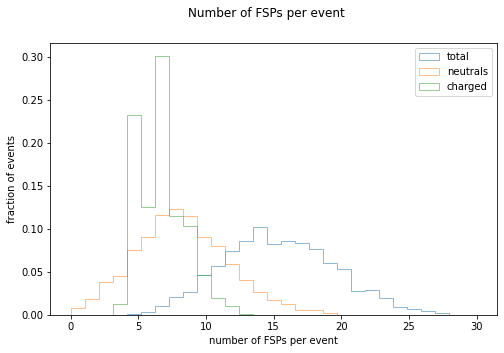

In [6]:
bins = np.linspace(0, 30, 30)
neutrals = df_FSPs[df_FSPs["PDG"] == 22.]
charged = df_FSPs[df_FSPs["PDG"] != 22.]

numFSPs_all = pd.DataFrame({'count' : df_FSPs.groupby( ["__event__"] ).size()}).reset_index()
numFSPs_charged = pd.DataFrame({'count' : charged.groupby( ["__event__"] ).size()}).reset_index()
numFSPs_neutral = pd.DataFrame({'count' : neutrals.groupby( ["__event__"] ).size()}).reset_index()


fig, ax = plt.subplots()
fig.suptitle(r'Number of FSPs per event')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of FSPs per event')
ax.set_ylabel("fraction of events")

ax.hist(numFSPs_all["count"],bins=bins,density=True, alpha=0.5, label=(r'total'),histtype='step')
ax.hist(numFSPs_neutral["count"],bins=bins,density=True, alpha=0.5, label=(r'neutrals'),histtype='step')
ax.hist(numFSPs_charged["count"],bins=bins,density=True, alpha=0.5, label=(r'charged'),histtype='step')

ax.legend(loc='upper right')


plt.savefig('numFSPs_Gmodes_basf2Performance.pdf')

In [28]:
numFSPs_all = pd.DataFrame({'count' : df_FSPs.groupby( ["__event__"] ).size()}).reset_index()
numFSPs_all["count"].describe()

count    51903.000000
mean        26.252876
std          5.850494
min          7.000000
25%         22.000000
50%         26.000000
75%         30.000000
max         65.000000
Name: count, dtype: float64

## check the assignment accuracy of basf2

In [29]:
groupsAllFSPs = pd.DataFrame({'count' : df_FSPs.groupby(["label","basf2_label"]).size()}).reset_index()
groupsAllFSPs

,label,basf2_label,count
0,0,0,420653
1,0,1,107504
2,0,2,21493
3,1,0,147071
4,1,1,350888
5,1,2,314994


In [30]:
print("accuracy of basf2 for all particles:",round(df_FSPs[df_FSPs["basf2_correct"] == True].shape[0] / df_FSPs.shape[0] *100,2),'%')

accuracy of basf2 for all particles: 56.62 %


In [31]:
numFSPs.shape[0]

51903

In [32]:
groupsAllFSPs = pd.DataFrame({'corrects' : df_FSPs.groupby( ["__event__","basf2_correct"] ).size()}).reset_index()
basf2_failureCount = groupsAllFSPs[groupsAllFSPs["basf2_correct"] == True]

numFSPs = pd.DataFrame({'numFSPs' : df_FSPs.groupby(["__event__"]).size()}).reset_index()

basf2_stats = pd.merge(basf2_failureCount[["__event__","corrects"]],numFSPs[["__event__","numFSPs"]], on="__event__")


basf2_stats

,__event__,corrects,numFSPs
0,557,12,25
1,903,21,30
2,2070,20,34
3,2646,20,27
4,3403,19,32
...,...,...,...
51898,50996982,20,34
51899,50997399,14,24
51900,50997576,10,21
51901,50997788,12,26


In [33]:
basf2_stats["wrongs"] = basf2_stats["numFSPs"] - basf2_stats["corrects"] 
basf2_stats

,__event__,corrects,numFSPs,wrongs
0,557,12,25,13
1,903,21,30,9
2,2070,20,34,14
3,2646,20,27,7
4,3403,19,32,13
...,...,...,...,...
51898,50996982,20,34,14
51899,50997399,14,24,10
51900,50997576,10,21,11
51901,50997788,12,26,14


In [ ]:
bins = np.linspace(0, 30, 30)
fig, ax = plt.subplots()
fig.suptitle(r'----')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of wrong assignments per event')
ax.set_ylabel("fraction of total events")

ax.hist(basf2_stats["wrongs"],bins=bins,density=True, alpha=0.5, label=(r'---'),histtype='step')
#ax.hist(numFSPs_charged["count"],bins=bins,density=True, alpha=0.5, label=(r'charged'),histtype='step')
#ax.hist(numFSPs["count"],bins=bins,density=True, alpha=0.5, label=(r'total'),histtype='step')




ax.legend(loc='upper right')

#plt.savefig('dataSetAnaPlots/numFSPs_histo_NAHSrun1_neutrals_charged.pdf')

In [34]:
print("accuracy of basf2 for all particles:",round(df_FSPs[df_FSPs["basf2_correct"] == True].shape[0] / df_FSPs.shape[0] *100,2),'%')

print("BASF2 assignment errors per event \n")

numEvts = basf2_stats.shape[0]
for i in range(4):
    print(i, 'errors:', round(basf2_stats[basf2_stats["wrongs"] == i].shape[0]  /  numEvts * 100, 2),'%')

i = 3
print('more than',i, 'errors:', round(basf2_stats[basf2_stats["wrongs"] > i].shape[0]  /  numEvts * 100, 2),'%')

accuracy of basf2 for all particles: 56.62 %
BASF2 assignment errors per event 

0 errors: 0.0 %
1 errors: 0.0 %
2 errors: 0.0 %
3 errors: 0.0 %
more than 3 errors: 100.0 %


In [35]:
basf2_stats["wrongs"].describe()

count    51903.000000
mean        11.387820
std          2.803105
min          4.000000
25%          9.000000
50%         11.000000
75%         13.000000
max         27.000000
Name: wrongs, dtype: float64